---
title: Regularization methods - lasso, ridge, and elastic net
teaching: 45
exercises: 2
keypoints:
- ""
objectives:
- ""
questions:
- "How can LASSO regularization be used as a feature selection method?"
---

## Introduction to the LASSO model in high-dimensional data analysis
In the realm of high-dimensional data analysis, where the number of predictors begins to approach or exceed the number of observations, traditional regression methods can become challenging to implement and interpret. The Least Absolute Shrinkage and Selection Operator (LASSO) offers a powerful solution to address the complexities of high-dimensional datasets. This technique, introduced by Robert Tibshirani in 1996, has gained immense popularity due to its ability to provide both effective prediction and feature selection.

The LASSO model is a regularization technique designed to combat overfitting by adding a penalty term to the regression equation. The essence of the LASSO lies in its ability to shrink the coefficients of less relevant predictors towards zero, effectively "shrinking" them out of the model. This not only enhances model interpretability by identifying the most important predictors but also reduces the risk of multicollinearity and improves predictive accuracy.

LASSO's impact on high-dimensional data analysis is profound. It provides several benefits:

* **Feature Selection / Interpretability**: The LASSO identifies and retains the most relevant predictors. With a reduced set of predictors, the model becomes more interpretable, enabling researchers to understand the driving features behind the predictions.

* **Improved Generalization**: The L1 penalty prevents overfitting by constraining the coefficients, even in cases with a large number of predictors. The L1 penality inherently reduces the dimensionality of the model, making it suitable for settings where the number of predictors is larger than the sample size.

* **Data Efficiency**: LASSO excels when working with limited samples, offering meaningful insights despite limited observations.

### The L1 penalty
The key concept behind the LASSO is its use of the L1 penalty, which is defined as the sum of the absolute values of the coefficients (parameters) of the model, multiplied by a regularization parameter (usually denoted as λ or alpha).

In the context of linear regression, the L1 penalty can be incorporated into the ordinary least squares (OLS) loss function as follows:

![LASSO Model](https://www.analyticsvidhya.com/wp-content/uploads/2015/08/Lasso.png)


Where:

* λ (lambda) is the regularization parameter that controls the strength of the penalty. Higher values of λ lead to stronger regularization and more coefficients being pushed towards zero.
* βi is the coefficient associated with the i-th predictor.

The L1 penalty has a unique property that it promotes sparsity. This means that it encourages some coefficients to be exactly zero, effectively performing feature selection. In contrast to the L2 penalty (Ridge penalty), which squares the coefficients and promotes small but non-zero values, the L1 penalty tends to lead to sparse solutions where only a subset of predictors are chosen. As a result, the LASSO automatically performs feature selection, which is especially advantageous when dealing with high-dimensional datasets where many predictors may have negligible effects on the outcome.

## Compare full-dim and LASSO results

### Load full dim, zscored, data
We'll use most of the data for the test set so that this dataset's dimensionality begins to approach the number of observations. Regularization techniques such as LASSO tend to shine when working in this context. If you have plenty of data to estimate each coefficient, you will typically find that an unregularized model performs better.

In [1]:
from preprocessing import prep_fulldim_zdata
X_train_z, X_holdout_z, y_train, y_holdout, y = prep_fulldim_zdata(const_thresh= 95, test_size=.95, y_log_scaled=True)

from sklearn.model_selection import train_test_split
X_val_z, X_test_z, y_val, y_test = train_test_split(X_holdout_z, y_holdout, test_size=0.5, random_state=0)
X_train_z.head()

133 columns removed, 82 remaining.
Columns removed: ['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'PoolArea', '3SsnPorch', 'KitchenAbvGr', 'LowQualFinSF', 'MasVnrType_BrkCmn', 'RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NPkVill', 'Neighborhood_NoRidge', 'Neighborhood_SWISU', 'Neighborhood_SawyerW', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'LandContour_Bnk', 'LandContour_HLS',

,GrLivArea,MoSold,OverallCond,WoodDeckSF,EnclosedPorch,YrSold,Fireplaces,YearBuilt,GarageArea,BedroomAbvGr,...,Exterior2nd_Plywood,Exterior2nd_VinylSd,BldgType_1Fam,BldgType_TwnhsE,Condition1_Feedr,Condition1_Norm,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,CentralAir
633,-0.961978,0.169179,1.419048,2.007070,-0.251998,-0.495091,-0.925321,-0.807251,-1.031070,0.241741,...,-0.395671,-0.760865,0.526172,-0.323431,-0.239117,0.348412,-0.239117,1.093397,-0.927282,0.166683
908,-1.313923,-0.164606,-0.430783,0.434247,-0.251998,-1.203750,-0.925321,0.317799,0.113304,-1.018765,...,-0.395671,-0.760865,0.526172,-0.323431,-0.239117,0.348412,-0.239117,1.093397,-0.927282,0.166683
611,-1.016827,0.169179,0.494133,-0.707093,-0.251998,-0.495091,0.682975,0.123825,0.522008,0.241741,...,-0.395671,-0.760865,0.526172,-0.323431,-0.239117,0.348412,-0.239117,1.093397,-0.927282,0.166683
398,-0.913986,1.504320,-3.205529,-0.707093,-0.251998,-0.495091,-0.925321,-2.126275,-0.632583,-1.018765,...,-0.395671,-0.760865,0.526172,-0.323431,-0.239117,0.348412,4.124766,-0.902052,-0.927282,0.166683
91,-0.552900,1.838105,-2.280614,-0.707093,-0.251998,-1.203750,-0.925321,-0.535687,0.092868,-1.018765,...,-0.395671,-0.760865,0.526172,-0.323431,-0.239117,0.348412,-0.239117,1.093397,-0.927282,0.166683


In [2]:
print(X_train_z.shape)

(73, 82)


## Intro to LassoCV
LassoCV in scikit-learn performs cross-validation to find the best alpha value (lambdas in traditional LASSO equation) from the specified list of alphas. It does this by fitting a separate LASSO regression for each alpha value on each fold of the cross-validation. The alphas parameter determines the values of alpha to be tested.

**Cross-validation** is a method used to assess the performance and generalizability of a machine learning model. It involves partitioning the dataset into multiple subsets, training the model on some of these subsets, and then evaluating its performance on the remaining subset(s). 

For example, in 5-fold cross-validation, you split your data into 5 partitions ("folds"). You then train the model on 4 of the folds, leaving one out for validation. You do this 5 times — training/validating on different folds each time.

The LassoCV() functions returns the best model that was determined based on cross-validation performance. This best model's coefficients can be accessed using the .coef_ attribute, and the optimal alpha can be accessed using the .alpha_ attribute.

In [3]:
from sklearn.linear_model import LassoCV
# help(LassoCV)

### Specify range of alphas to evaluate
Specify a range of alpha values. Typically, small alphas work well. However, you don't want to be so close to zero that you get no benefits from regularization (i.e., none of the coefs shrink to zero).

In [4]:
import numpy as np
alphas = np.logspace(-4, 1, 100) # The alphas you want to evaluate during cross-validation
alphas_with_zero = np.insert(alphas, 0, 0) # The unregularized model
print(alphas_with_zero[0:10])

max_iter = 100000 # This is the maximum number of iterations for which we want the model to run if it doesn’t converge before reaching this number. The default value is 1000

cv = 5 # number of folds to use during cross-validation

[0.         0.0001     0.00011233 0.00012619 0.00014175 0.00015923
 0.00017886 0.00020092 0.0002257  0.00025354]


### Call LassoCV


In [5]:
lasso_cv = LassoCV(alphas=alphas, cv=cv, max_iter=max_iter, random_state=0)

### Randomness in LassoCV
LassoCV uses coordinate descent, which is a convex optimization algorithm meaning that it solves for a global optimum (one possible optimum).

However, during coordinate descent, when multiple features are highly correlated, the algorithm can choose any one of them to update at each iteration. This can lead to some randomness in the selection of features and the order in which they are updated. While coordinate descent itself is deterministic, the order in which the correlated features are selected can introduce variability.

The random state argument in LassoCV allows you to control this randomness by setting a specific random seed. This can be helpful for reproducibility when working with models that involve correlated features. By specifying a random seed, you ensure that the same features will be chosen in the same order across different runs of the algorithm, making the results more predictable and reproducible.

In summary, while coordinate descent is a convex algorithm, the random state argument in LassoCV helps manage the potential randomness introduced by the selection of correlated features during the optimization process.

In [6]:
# fit the model
best_lasso_model = lasso_cv.fit(X_train_z, y_train)

Print the best alpha value selected.

In [7]:
best_lasso_model.alpha_

0.0093260334688322

Print the coefs

In [8]:
coefs = best_lasso_model.coef_
coefs

array([ 0.08295882, -0.01380859,  0.03153   ,  0.02955373,  0.00996286,
       -0.        ,  0.04028652,  0.03152201,  0.00409952,  0.        ,
        0.        ,  0.        ,  0.        ,  0.02593301,  0.        ,
        0.00141221, -0.        ,  0.06602105,  0.00060508,  0.        ,
        0.        ,  0.06136738, -0.        ,  0.        ,  0.        ,
        0.01326941,  0.06097473,  0.00380414, -0.        , -0.        ,
        0.00016823, -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.02452494,  0.0223447 , -0.02467728,
        0.        , -0.02635082,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.00602431, -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.0488774 ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.  

Assess sparsity

In [9]:
percent_sparsity = np.mean(coefs == 0) * 100
percent_sparsity

63.41463414634146

Evaluate model error

In [10]:
from regression_predict_sklearn import measure_model_err
# to calculate residuals and R-squared for the test set, we'll need to get the model predictions first
y_pred_train = best_lasso_model.predict(X_train_z)
y_pred_test = best_lasso_model.predict(X_test_z)
errors_df = measure_model_err(y, np.mean(y),
                              y_train, y_pred_train,
                              y_test, y_pred_test,
                              'RMSE', y_log_scaled=True) 
errors_df.head()

,Baseline Error,Train Error,Test Error
0,79415.291886,13762.95373,55999.689566


### Use fit_eval_model() to quickly compare models

# of predictor vars = 82
# of train observations = 73
# of test observations = 694
Baseline RMSE = 79415.29188606751
Train RMSE = 2.9883282815358944e-10
Holdout RMSE = 2357924.397902944
(Holdout-Train)/Train: 789044634912418048%


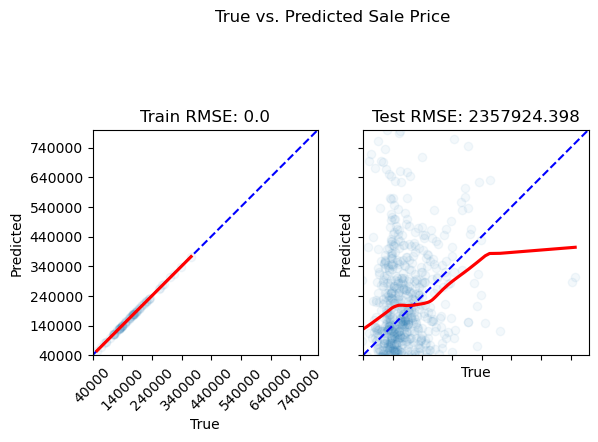


# of predictor vars = 82
# of train observations = 73
# of test observations = 694
Baseline RMSE = 79415.29188606751
Train RMSE = 13762.95373005899
Holdout RMSE = 55999.68956595316
(Holdout-Train)/Train: 307%


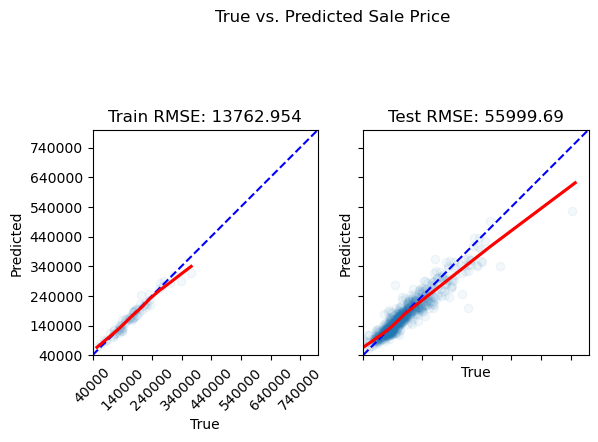

In [11]:
from regression_predict_sklearn import fit_eval_model

# Full-dim model
fulldim_model, error_df = fit_eval_model(y=y, baseline_pred=y.mean(),
               X_train=X_train_z, y_train=y_train,
               X_test=X_test_z, y_test=y_test, 
               predictors=X_train_z.columns,
               metric='RMSE',
               y_log_scaled=True,
               model_type='unregularized',
               include_plots=True, plot_raw=True, verbose=True)

# LASSO
import numpy as np
best_lasso_model, error_df = fit_eval_model(y=y, baseline_pred=y.mean(),
                                         X_train=X_train_z, y_train=y_train,
                                         X_test=X_test_z, y_test=y_test, 
                                         predictors=X_train_z.columns,
                                         metric='RMSE',
                                         y_log_scaled=True,
                                         model_type='LassoCV', alphas=alphas, cv=cv, max_iter=max_iter,
                                         include_plots=True, plot_raw=True, verbose=True)

### Investivating the alpha hyperparameter
Here, we will take a closer look at the alpha hyperparameter to see which values performed well.

We will see different values of alpha impact:
* train error 
* validation error
* coefficient sparsity

Unfortunately for us, the LassoCV function in scikit-learn doesn't store the train errors for each model evaluated. It's primarily designed to perform cross-validation to find the best alpha value for Lasso regression regularization. For our purposes, we will have to manually run Lasso for each alpha value.

Typically when comparing alpha values, you're in the model selection stage of your analysis. This means that you need to use the validation set to evaluate performance. LassoCV does this implicitly by using portions of the training data as validation data. Here, we'll use the explicit validation set we defined at the beginning of this episode.

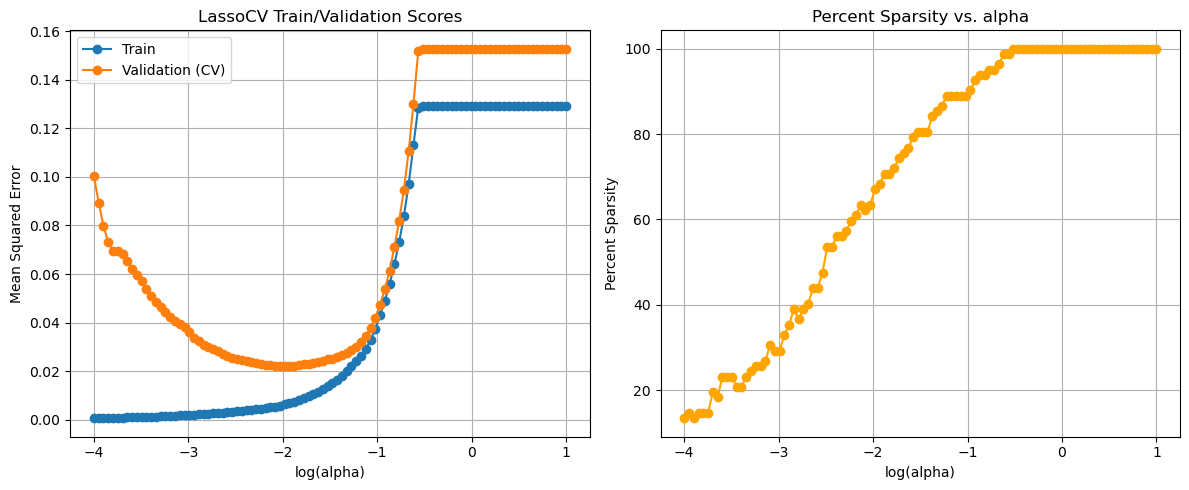

In [12]:
import matplotlib.pyplot as plt
# Calculate the corresponding training scores for each alpha and fold
from sklearn.linear_model import Lasso
train_scores = []
val_scores = []

perc_sparse_vals = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=max_iter)
    lasso.fit(X_train_z, y_train)
    coefs = lasso.coef_
    percent_sparse = np.mean(coefs == 0) * 100
    train_pred = lasso.predict(X_train_z)
    val_pred = lasso.predict(X_val_z)
    train_scores.append(np.mean((train_pred - y_train) ** 2))
    val_scores.append(np.mean((val_pred - y_val) ** 2))
    perc_sparse_vals.append(percent_sparse)

# Create a grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the training and validation scores
ax1.plot(np.log10(alphas), train_scores, label='Train', marker='o')
ax1.plot(np.log10(alphas), val_scores, label='Validation (CV)', marker='o')
ax1.set_xlabel('log(alpha)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('LassoCV Train/Validation Scores')
ax1.legend()
ax1.grid(True)

# Plot percent sparsity
ax2.plot(np.log10(alphas), perc_sparse_vals, label='Percent Sparsity', marker='o', color='orange')
ax2.set_xlabel('log(alpha)')
ax2.set_ylabel('Percent Sparsity')
ax2.set_title('Percent Sparsity vs. alpha')
ax2.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig('..//fig//regression//regularize//alpha_cv_results.png', bbox_inches='tight', dpi=300, facecolor='white');


<img src="../fig/regression/regularize/alpha_cv_results.png"  align="center" width="60%" height="60%">

### LASSO as a feature selection method
A well optimized LASSO model can be used as a data-driven feature selection method. However, one thing to be mindful of is, given two features that are correlated, LASSO may randomly select one feature's coefficient to shrink to zero. This can sometimes lead to less desirable model specifications. However, if you have one are more features that you want to ensure are included in the model, you can follow this procedure:

1. Fit the LassoCV model to determine the optimal features to keep in the model, `feats_keep`
2. Extend the list of `feats_keep` to include other features/predictors that are important to your research questions
3. Fit a standard unregularized model using `feats_keep` as your predictors
4. Take care to check the assumptions of the model, especially if you're adding features after selecting them with LASSO. LASSO helps prevent multicollinearity issues, but adding features back in could re-introduce multicollinearity

Let's see which features our best LASSO model decided to keep.

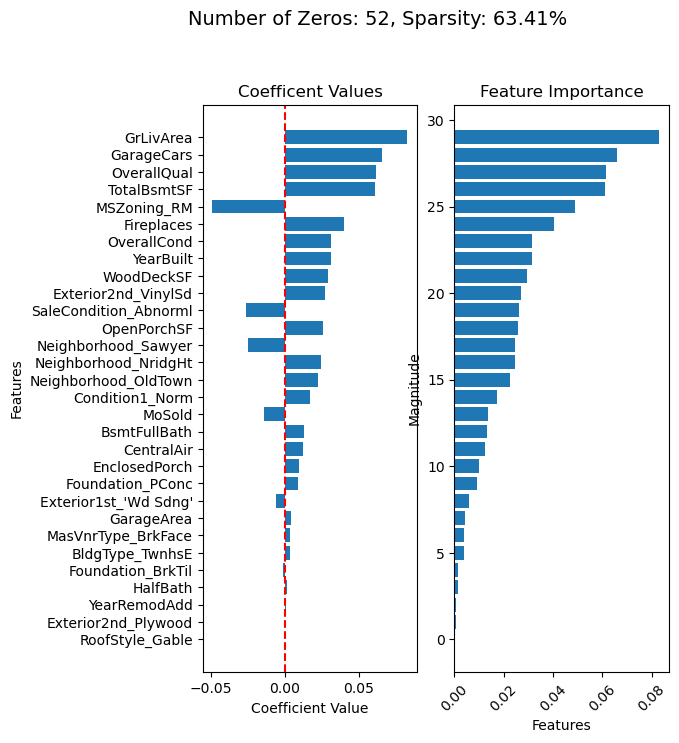

In [13]:
from interpret_model import coef_plot

# Get coefficient matrix
coef_matrix = best_lasso_model.coef_

fig = coef_plot(coefs=coef_matrix, plot_const=False, index=X_train_z.columns) 
fig.set_size_inches(6, 8)

## Introduction to the ridge model in high-dimensional data analysis
Ridge regression introduces an L2 penalty term to the linear regression equation, which involves adding the squared magnitudes of the coefficients to the loss function. This regularization technique aims to minimize the sum of squared residuals while also constraining the coefficients. Here are some key points about Ridge regression:

* **Coefficient Shrinkage**: Ridge regression shrinks the coefficients towards zero by penalizing their magnitudes. However, unlike Lasso, Ridge regression does not force any coefficients to become exactly zero.

* **Multicollinearity Mitigation**: Both Ridge and Lasso provide ways to handle multicollinearity, but their mechanisms and outcomes are somewhat different. Ridge regression provides a more continuous shrinkage of coefficients, while Lasso can lead to sparse models with only a subset of predictors retained.

* **Inclusion of All Predictors**: Ridge regression retains all predictors in the model, even if some predictors have relatively small coefficients. This can be beneficial when you believe that most predictors contribute to the outcome, but you want to reduce their impact to avoid overfitting.

* **Bias-Variance Trade-off (avoids overfitting)**: Ridge regression strikes a balance between bias and variance. It can reduce the risk of overfitting without excluding any predictors from the model, making it a useful tool when working with high-dimensional datasets.

In summary, Ridge regression and Lasso are regularization techniques that address high-dimensional data analysis challenges in distinct ways. Ridge regression is effective for stabilizing coefficient estimates and managing multicollinearity. Lasso excels in situations where feature selection and interpretability are essential, but it might sacrifice some predictive accuracy for simplicity. The choice between Ridge regression and Lasso depends on the specific goals of your analysis and the nature of your dataset.

In [19]:
from sklearn.linear_model import LinearRegression, RidgeCV

ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)  # store_cv_values=True to enable cv_values_

# Fit the RidgeCV model
ridge_cv.fit(X_train_z, y_train)

# Print the chosen alpha and corresponding R-squared score
print("Chosen Alpha:", ridge_cv.alpha_)
print("R-squared Score:", ridge_cv.score(X_test_z, y_test))

Chosen Alpha: 10.0
R-squared Score: 0.810842060991108


In [21]:
# Full-dimensional linear regression
full_dim_model = LinearRegression()
full_dim_model.fit(X_train_z, y_train)
full_dim_r2 = full_dim_model.score(X_test_z, y_test)
print("R-squared Score:", full_dim_r2)

R-squared Score: -7.321193011831625


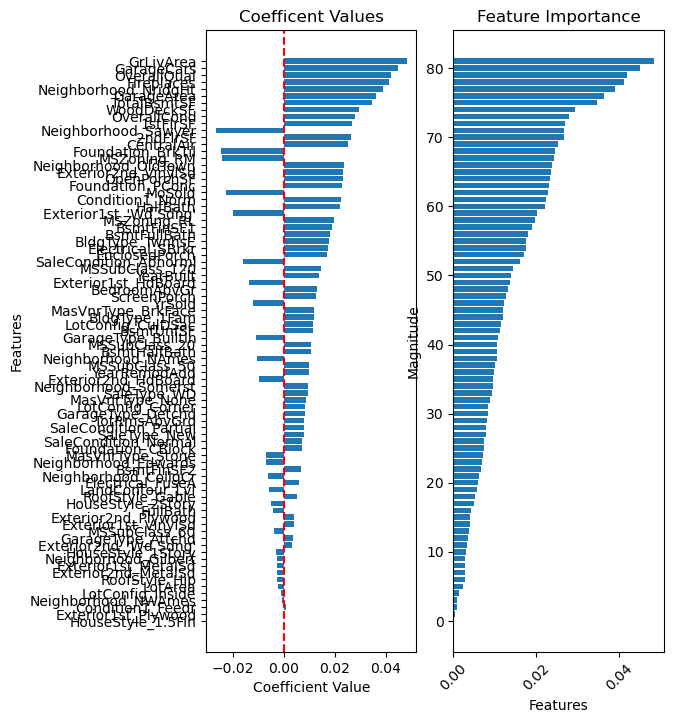

In [22]:
from interpret_model import coef_plot

# Get coefficient matrix
coef_matrix = ridge_cv.coef_

fig = coef_plot(coefs=coef_matrix, plot_const=False, index=X_train_z.columns) 
fig.set_size_inches(6, 8)